# BlackJack : Monte-Carlo with Exploring Start
----

## 설명
블랙잭 게임에서의 최적 Policy를 찾는 프로그램입니다. 본 프로그램에서 정의된 블랙잭 룰은 다음과 같습니다.
 - 하나의 카드 덱(조커를 제외한 52장의 카드)을 사용
 - 카드의 합을 계산할 시 A = 1 or 11, J,Q,K = 10으로 계산
 - 플레이어는 Hit 또는 Stick만을 할 수 있음
 - 카드의 합이 21 이하일 경우, 딜러와 플레이어 중 숫자가 더 높은 쪽이 승리.
 - 카드의 합이 21 초과한 딜러/플레이어는 패배
 - 카드의 합이 같을 경우 무승부

본 프로그램에서는 최적 Policy를 찾기 위해 Monte-Carlo Control with Exploring Start[1] 알고리즘을 사용합니다. 최적 Policy를 찾기 위해, 본 프로그램은 다음과 같은 변수로 구성된 State로부터 탐색을 수행합니다.
 - 플레이어 카드의 합 : 12 ~ 21 사이의 정수
 - 딜러가 보여주는 카드의 숫자 : 1 ~ 10 사이의 정수
 - 플레이어가 현재 사용 가능한 Ace의 유무 : True / False

위와 같이 구성된 State S에서 Action A를 선택했을 때의 기대 리턴(게임이 끝났을 때 얻을 것으로 기대되는 보상의 합)은 Q(S,A)입니다. 많은 에피소드를 경험할수혹 Agent는 Optimal Q(S,A)에 가까운 값을 학습하게 되며, 이로부터 최적 Policy를 찾을 수 있습니다.

----

## 0. Package
먼저 본 프로그램에서 사용할 Package를 Import합니다.

In [1]:
%matplotlib inline
import random
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

## 1. Class : Deck
카드 덱 한 벌에 해당하는 클래스를 선언합니다. 조커를 제외한 52장의 카드로 이루어져 있으며, 각 카드는 정수로 표기됩니다. <br>
A = 11, J, Q, K = 10으로 표현되며, 나머지 카드는 해당 카드에 적힌 숫자만큼의 값을 갖습니다.

### 클래스 구성
* Attributes
   * card_deck : List, 52개의 정수로 이루어짐
* Methods
   * shuffle() : 카드 덱을 랜덤하게 섞음
   * draw() : 카드 덱에서 한 장을 뽑아 리턴
   * reset() : 카드 덱을 초기화함

In [2]:
class Deck(object):
    """
    Deck : Card deck, which can be shuffled, drawn, and reset.
    """

    def __init__(self):
        deck = [2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 11]
        self.card_deck = deck * 4
        self.shuffle()

    def shuffle(self):
        random.shuffle(self.card_deck)

    def draw(self):
        return self.card_deck.pop()

    def reset(self):
        deck = [2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 11]
        self.card_deck = deck * 4
        self.shuffle()

## 2. Class : Dealer
다음으로 Dealer 클래스를 선언합니다.<br> 
Dealer 클래스는 강화학습에서의 Environment에 해당합니다. 플레이어의 Action을 받고, 그에 따른 다음 State와 Reward를 반환합니다.<br>
딜러는 시작할 때 두 장의 카드를 받습니다. 플레이어의 차례가 끝난 후, 플레이어의 카드 합이 21을 넘지 않는다면 딜러는 다음과 같이 행동합니다.
 - 딜러 카드의 합이 17 미만일 때 : 카드 한 장을 추가로 뽑음 (Hit)
 - 딜러 카드의 합이 17 이상일 때 : 플레이어의 카드 합과 비교하여 승패 결정 (Stick)

### 클래스 구성
딜러 클래스는 다음과 같이 구성됩니다
 - Attributes
     - hands : List, 딜러가 가지고 있는 카드들
     - usable_ace : List, 딜러가 가지고 있는 A의 인덱스
 - Methods 
     - hit(deck) : 카드 덱에서 카드 한 장을 뽑아 hands에 추가
     - show() : 딜러가 가진 카드 중 랜덤한 한 장의 값을 리턴
     - calculate_sum() : 딜러가 가진 카드의 합을 리턴. 카드 합이 21 이상일 때 사용 가능한 Ace가 있다면 사용함.
     - action() : 딜러의 Action - 합이 17 미만이면 hit, 이상이면 stick
     - observation(action, agent, deck) : 플레이어의 action을 받아 종료 여부와 reward 리턴
     - calculate_rewards(agent, deck) : 플레이어와 딜러의 승패 계산 및 reward 리턴
     - reset() : 딜러 클래스의 모든 attribute 초기화

In [3]:
class Dealer(object):
    """
    Dealer : 딜러 클래스
    딜러는 두 장의 카드를 받고, 카드의 합이 16 이하이면 Hit, 17이상이면 Stick 함.
    처음 두 장을 받았을 때 한 장의 카드를 랜덤하게 오픈함.
    """

    def __init__(self):
        """
        hand : 딜러가 가진 카드
        usable_ace : 딜러가 가진 카드 리스트 중 ace의 인덱스
        natural : 두 장의 카드로 21이 되면 True, 아니면 False
        """
        self.hands = list()
        self.usable_ace = list()

    def hit(self, deck: Deck):
        """
        딜러의 Hit. 새로운 카드가 Ace라면 사용 가능한 Ace 리스트에 추가함
        :param deck: Deck Object
        :return:
        """
        new_card = deck.draw()
        if new_card == 11:
            self.usable_ace.append(len(self.hands))
        self.hands.append(new_card)

    def show(self):
        """
        딜러가 가진 카드 중 하나를 랜덤하게 보여줌
        :return: 딜러의 카드 중 랜덤한 카드 숫자
        """
        card = random.choice(self.hands)
        if card == 11:
            card = 1
        return card

    def calculate_sum(self):
        """
        딜러가 가진 카드의 합을 구함
        21을 넘을 때 사용 가능한 Ace가 있으면 사용함
        :return: 딜러 카드의 합
        """
        sums = sum(self.hands)
        if sums > 21 and len(self.usable_ace) > 0:
            self.hands[self.usable_ace.pop()] = 1
            sums = sum(self.hands)
        return sums

    def action(self, deck: Deck):
        """
        딜러의 순서 때 딜러의 행동.
        숫자의 합이 16 이하일 때는 Hit, 17 이상이면 Stick
        :param deck:
        :return:
        """
        while True:
            sums = self.calculate_sum()
            if sums < 17:
                self.hit(deck)
            else:
                return sums

    def observation(self, action, agent, deck):
        """
        플레이어의 Action을 받아, 그에 맞는 Observation과 Reward를 반환
        :param action: agent 의 Action
        :param agent: agent 클래스
        :param deck: deck 클래스
        :return: 에피소드 종료 여부, reward
        """
        done = False
        reward = 0
        if action == True:  # Hit
            agent.hit(deck)
            if agent.calculate_sum() > 21:  #플레이어의 Hit으로 인해 카드 합이 21이 넘으면 즉시 종료
                done = True
                reward = -1
        else:  # Stick
            done = True
            reward = self.calcuate_reward(agent, deck)

        return done, reward

    def calcuate_reward(self, agent, deck):
        """
        플레이어가 Stick했을 때 딜러와의 카드 비교 수행
        :param agent:
        :param deck:
        :return: Reward
        """
        agent_sum = agent.calculate_sum()           # 플레이어의 카드 합 계산
        if agent_sum > 21:                          # 플레이어의 Bust (패)
            return -1

        dealer_sum = self.action(deck)              # 딜러의 카드 합 계산
        if dealer_sum > 21:                         # 딜러가 Bust (승)
            return 1
        if dealer_sum > agent_sum:                  # 딜러의 카드 합 > 플레이어 합 (패)
            return -1
        if dealer_sum < agent_sum:                  # 딜러의 카드 합 < 플레이어 합 (승)
            return 1
        return 0                                   # 딜러의 카드 합 == 플레이어의 합 (무)

    def reset(self):
        """
        딜러 초기화 (새로운 에피소드 시작을 위해)
        """
        self.hands = list()
        self.usable_ace = list()

## 3. Class : Agent
Agent 클래스는 플레이어에 해당하며, 최적 Policy를 학습하는 주체가 됩니다. Agent는 여러 에피소드들로부터 Q값(기대 Return)을 계산하고, 다음 에피소드 수행 시 해당 State에서 Q값이 높은 Action을 선택하는 Greedy Policy를 따릅니다. 

### 클래스 구성

Agent의 구성은 다음과 같습니다.

 - Attributes
     - hands : List, Agent가 가지고 있는 카드들
     - usable_ace : List, Agent가 가지고 있는 A의 인덱스
     - Q_table : Dictionary, 기대 Return값과 방문 횟수를 저장
 - Methods 
     - hit(deck) : 카드 덱에서 카드 한 장을 뽑아 hands에 추가
     - calculate_sum() : Agent가 가진 카드의 합을 리턴. 카드 합이 21 이상일 때 사용 가능한 Ace가 있다면 사용함.
     - random_action() : 현재 State에 상관없이 랜덤하게 Action을 리턴
     - policy(state) : 현재 State에서 가능한 Action 중, Q_table의 값이 큰 Action을 리턴
     - update_qval(episode) : 에피소드로부터 평균 리턴을 계산하여 Q_table을 업데이트
     - reset() : Agent 클래스의 모든 attribute 초기화

In [4]:
class Agent(object):
    def __init__(self):
        """
        hand : 플레이어의 카드
        usable_ace : 사용 가능한 ace 리스트
        Q_table : q(s,a) 값을 저장할 딕셔너리
        """
        self.hands = list()
        self.usable_ace = list()
        self.Q_table = dict()

    def hit(self, deck: Deck):
        """
        덱에서 새로운 카드를 뽑음
        :param deck: Deck for draw a card
        :return: None
        """
        new_card = deck.draw()
        if new_card == 11:
            self.usable_ace.append(len(self.hands))
        self.hands.append(new_card)

    def calculate_sum(self):
        """
        플레이어가 가진 카드의 합을 구함.
        21을 넘을 때 사용 가능한 ace가 있으면 사용함
        :return:
        """
        sums = sum(self.hands)
        if sums > 21 and len(self.usable_ace) > 0:
            self.hands[self.usable_ace.pop()] = 1
            sums = sum(self.hands)
        return sums

    def random_action(self):
        """
        랜덤하게 행동
        True = hit, False = stick
        :return:
        """
        return random.choice([True, False])

    def policy(self, state):
        """
        Agent의 policy 함수.
        e의 확률로 랜덤 행동을 하며, 그 외에는 현재 state에서 큰 q(s,a)값을 갖는 action을 선택함
        :param state: Agent에게 주어진 state
        :return: agent의 action을 반환 , True = hit and False = stick
        """
        # Q_table에서 현재 state-action에 대해 값이 존재하는지 검사함
        for action in (True, False):
            if (state, action) not in self.Q_table.keys():  # Q_table에 값이 없으면 0으로 초기화
                self.Q_table[(state, action)] = [0, 0]      # (mean return, visit count)
            else:
                continue

        # q값이 큰 action 선택
        if self.Q_table[(state, True)] > self.Q_table[(state, False)]:
            return True     # Hit
        elif self.Q_table[(state, True)] == self.Q_table[(state, False)]:   # q값이 같으면 무작위추출
            return self.random_action()
        else:
            return False    # Stick


    def reset(self):
        """
        Agent를 리셋함
        :return: None
        """
        self.hands = list()
        self.usable_ace = list()

    def update_qval(self, episode):
        """
        에피소드(한 번의 게임)으로부터 Q_table 을 업데이트함
        Q 테이블에 없는 state-action 쌍이 나오면 새로 생성
        Q 테이블에 state-action 쌍이 존재한다면 Incremental mean 적용하여 업데이트
        :param episode: Episode generated from environment
        :return: None
        """
        total_return = 0
        for state, action, reward in episode[::-1]:     # 에피소드의 뒤에서부터 (역순)
            total_return += reward                       # return Gt 계산
            if (state, action) not in self.Q_table.keys():  # state-action 쌍이 없다면
                self.Q_table[(state, action)] = [total_return, 1]   # 새롭게 엔트리 생성 (Gt, count)

            else:  #이미 존재하는 state-action 쌍이면 Incremental mean 적용
                prev_val = self.Q_table[(state, action)][0]         # 이전의 평균 return
                count = self.Q_table[(state, action)][1] + 1        # count 증가
                mean = prev_val + (total_return - prev_val) / count # 평균 계산 : Incremental Mean 적용
                self.Q_table[(state, action)] = [mean, count]  # 업데이트

## 4. Class : MonteCarlo
Monte-Carlo control with Exploring Start를 구현한 클래스입니다. 에피소드를 생성할 수 있고, 생성된 에피소드로부터 에이전트를 학습시킵니다.
에피소드 생성 시 Exploring Start를 위해 에피소드의 첫 번째 State에서는 무작위로 Action을 선택하며, 이후에는 에이전트의 Policy를 따라 Action을 선택합니다.

### 클래스 구성
MonteCarlo 클래스는 다음과 같이 구성됩니다.
 - Attribute
     - 없음
 - Methods 
     - generate_episode(dealer, agent, deck) : 딜러, 플레이어, 카드 덱을 이용해 한 번의 블랙잭 게임을 진행하고 에피소드를 반환합니다.
     - train(dealer, agent, deck, it, verbose) : 지정된 이터레이션 수만큼의 에피소드로부터 플레이어를 학습시킵니다.

In [5]:
class MonteCarlo(object):
    def generate_episode(self, dealer: Dealer, agent: Agent, deck: Deck):
        """
        하나의 에피소드(게임)를 생성함
        :param dealer:
        :param agent:
        :param deck:
        :return:
        """
        
        # 카드 덱, 딜러, Agent를 초기화
        deck.reset()
        dealer.reset()
        agent.reset()
        agent.hit(deck)
        agent.hit(deck)
        dealer.hit(deck)
        dealer.hit(deck)

        done = False    # 에피소드의 종료 여부

        episode = list()    # 에피소드

        show=dealer.show()
        while not done:
            # 에피소드가 끝날 때까지 State, Action, Reward를 생성
            sums = agent.calculate_sum()
            if sums < 12:
                agent.hit(deck)
                continue

            state = (sums, bool(agent.usable_ace), show)

            ########   Exploring Start ~!!!!!!!!! : 
            if len(episode) == 0:       # 첫번째 State 일 때는 무작위 Action 선택
                action =agent.random_action()
            else:                       # 그 외에는 Q 테이블에서 큰 값을 갖는 Action 선택
                action = agent.policy(state)
            
            done, reward = dealer.observation(action, agent, deck)  # 에피소드 종료 여부, Reward 계산
            
            # 생성된 State, Action, Reward를 에피소드에 추가
            episode.append([state, action, reward])

        return episode

    def train(self, dealer: Dealer, agent: Agent, deck: Deck, it=1000, verbose=True):
        count = 0
        win = 0
        loss = 0
        draw = 0
        total_win = 0
        total_loss = 0
        total_draw = 0
        result = str()
        for i in range(it):
            count += 1
            episode = self.generate_episode(dealer, agent, deck)
            agent.update_qval(episode)

            if episode[-1][-1] == 1:
                win += 1
            elif episode[-1][-1] == 0:
                draw += 1
            else:
                loss += 1

            if count % 1000 == 0 and verbose == True:
                total_win += win
                total_loss += loss
                total_draw += draw

                print("========== Training : Episode ", count, " ===========")
                print("Recent 1000 games win rate :{:.3f}%".format(win / (win + loss) * 100))
                print(" -- 1000 Games WIN :", win, "DRAW :", draw, "LOSS :", loss)
                print("Total win rate : {:.3f}%".format(total_win / (total_win + total_loss) * 100))
                print(" -- TOTAL Games WIN :", total_win, "DRAW :", total_draw, "LOSS :", total_loss)

                win = 0
                loss = 0
                draw = 0
                

## 5. Function : plot_q_val(agent, usable_ace)
Q값을 시각화하기 위한 함수입니다.

In [6]:
def plot_q_val(agent: Agent, usable_ace=True):
    fig = plt.figure()
    ax = Axes3D(fig)

    hands = set()
    dealer_show = set()

    for state, action in sorted(agent.Q_table.keys()):
        hands.add(state[0])
        dealer_show.add(state[2])

    Z_list = list()

    l = list()

    for d in dealer_show:
        l = []
        for hand in hands:
            if ((hand, usable_ace, d), True) not in agent.Q_table.keys():
                agent.Q_table[((hand, usable_ace, d), True)] = [0, 0]
            if ((hand, usable_ace, d), False) not in agent.Q_table.keys():
                agent.Q_table[((hand, usable_ace, d), False)] = [0, 0]
            v_val = max([agent.Q_table[((hand, usable_ace, d), True)][0], agent.Q_table[((hand, usable_ace, d), False)][0]])
            l.append(v_val)
        Z_list.append(l)

    Y = np.array(list(hands))
    X = np.array(list(dealer_show))
    if usable_ace:
        X, Y = np.meshgrid(X, Y)
    else:
        X, Y = np.meshgrid(X, Y)

    Z = np.array(Z_list).T

    ax.plot_wireframe(X, Y, Z)
    plt.show()

## 6. Function : plot_q_val(agent, usable_ace)
최적 Policy를 시각화하기 위한 함수입니다.

In [7]:
def plot_action(agent: Agent, usable_ace=True):
    hands = set()
    dealer_show = set()

    for state, action in sorted(agent.Q_table.keys()):
        hands.add(state[0])
        dealer_show.add(state[2])

    Z_list = list()

    l = list()

    action = False

    for d in dealer_show:
        l = []
        for hand in hands:
            if ((hand, usable_ace, d), True) not in agent.Q_table.keys():
                agent.Q_table[((hand, usable_ace, d), True)] = [0, 0]
            if ((hand, usable_ace, d), False) not in agent.Q_table.keys():
                agent.Q_table[((hand, usable_ace, d), False)] = [0, 0]
            l.append(0 if agent.Q_table[((hand, usable_ace, d), True)][0] > agent.Q_table[((hand, usable_ace, d), False)][0] else 1)
        Z_list.append(l)

    Y = np.array(list(hands))
    X = np.array(list(dealer_show))
    if usable_ace:
        X, Y = np.meshgrid(X, Y)
    else:
        X, Y = np.meshgrid(X, Y)
    Z = np.array(Z_list).T

    data = Z[::-1,:]
    data = np.append(data, [0 for _ in range(Z[0].shape[0])]).reshape(-1,Z[0].shape[0])
    
    cmap=cm.coolwarm
    plt.imshow(data, cmap=cmap, extent=[1,11,11,21])

    plt.show()
    return X, Y, Z

## 7. 최적 Policy 학습


In [8]:
deck = Deck()
dealer = Dealer()
agent = Agent()
mc_es = MonteCarlo()

mc_es.train(dealer, agent, deck, it=1000000)

========== Training : Episode  1000  ===========
Recent 1000 games win rate :34.921%
 -- 1000 Games WIN : 330 DRAW : 55 LOSS : 615
Total win rate : 34.921%
 -- TOTAL Games WIN : 330 DRAW : 55 LOSS : 615
========== Training : Episode  2000  ===========
Recent 1000 games win rate :34.984%
 -- 1000 Games WIN : 325 DRAW : 71 LOSS : 604
Total win rate : 34.952%
 -- TOTAL Games WIN : 655 DRAW : 126 LOSS : 1219
========== Training : Episode  3000  ===========
Recent 1000 games win rate :33.758%
 -- 1000 Games WIN : 318 DRAW : 58 LOSS : 624
Total win rate : 34.553%
 -- TOTAL Games WIN : 973 DRAW : 184 LOSS : 1843
========== Training : Episode  4000  ===========
Recent 1000 games win rate :34.523%
 -- 1000 Games WIN : 329 DRAW : 47 LOSS : 624
Total win rate : 34.545%
 -- TOTAL Games WIN : 1302 DRAW : 231 LOSS : 2467
========== Training : Episode  5000  ===========
Recent 1000 games win rate :34.847%
 -- 1000 Games WIN : 330 DRAW : 53 LOSS : 617
Total win rate : 34.606%
 -- TOTAL Games WIN : 163

========== Training : Episode  46000  ===========
Recent 1000 games win rate :37.234%
 -- 1000 Games WIN : 350 DRAW : 60 LOSS : 590
Total win rate : 35.094%
 -- TOTAL Games WIN : 15188 DRAW : 2722 LOSS : 28090
========== Training : Episode  47000  ===========
Recent 1000 games win rate :36.296%
 -- 1000 Games WIN : 343 DRAW : 55 LOSS : 602
Total win rate : 35.120%
 -- TOTAL Games WIN : 15531 DRAW : 2777 LOSS : 28692
========== Training : Episode  48000  ===========
Recent 1000 games win rate :35.213%
 -- 1000 Games WIN : 331 DRAW : 60 LOSS : 609
Total win rate : 35.122%
 -- TOTAL Games WIN : 15862 DRAW : 2837 LOSS : 29301
========== Training : Episode  49000  ===========
Recent 1000 games win rate :32.762%
 -- 1000 Games WIN : 306 DRAW : 66 LOSS : 628
Total win rate : 35.074%
 -- TOTAL Games WIN : 16168 DRAW : 2903 LOSS : 29929
========== Training : Episode  50000  ===========
Recent 1000 games win rate :37.953%
 -- 1000 Games WIN : 356 DRAW : 62 LOSS : 582
Total win rate : 35.131%
 --

========== Training : Episode  89000  ===========
Recent 1000 games win rate :39.446%
 -- 1000 Games WIN : 370 DRAW : 62 LOSS : 568
Total win rate : 35.465%
 -- TOTAL Games WIN : 29692 DRAW : 5278 LOSS : 54030
========== Training : Episode  90000  ===========
Recent 1000 games win rate :34.183%
 -- 1000 Games WIN : 322 DRAW : 58 LOSS : 620
Total win rate : 35.451%
 -- TOTAL Games WIN : 30014 DRAW : 5336 LOSS : 54650
========== Training : Episode  91000  ===========
Recent 1000 games win rate :33.618%
 -- 1000 Games WIN : 315 DRAW : 63 LOSS : 622
Total win rate : 35.431%
 -- TOTAL Games WIN : 30329 DRAW : 5399 LOSS : 55272
========== Training : Episode  92000  ===========
Recent 1000 games win rate :36.004%
 -- 1000 Games WIN : 337 DRAW : 64 LOSS : 599
Total win rate : 35.437%
 -- TOTAL Games WIN : 30666 DRAW : 5463 LOSS : 55871
========== Training : Episode  93000  ===========
Recent 1000 games win rate :36.763%
 -- 1000 Games WIN : 343 DRAW : 67 LOSS : 590
Total win rate : 35.451%
 --

========== Training : Episode  129000  ===========
Recent 1000 games win rate :33.723%
 -- 1000 Games WIN : 317 DRAW : 60 LOSS : 623
Total win rate : 35.368%
 -- TOTAL Games WIN : 42915 DRAW : 7662 LOSS : 78423
========== Training : Episode  130000  ===========
Recent 1000 games win rate :33.405%
 -- 1000 Games WIN : 312 DRAW : 66 LOSS : 622
Total win rate : 35.353%
 -- TOTAL Games WIN : 43227 DRAW : 7728 LOSS : 79045
========== Training : Episode  131000  ===========
Recent 1000 games win rate :35.058%
 -- 1000 Games WIN : 332 DRAW : 53 LOSS : 615
Total win rate : 35.351%
 -- TOTAL Games WIN : 43559 DRAW : 7781 LOSS : 79660
========== Training : Episode  132000  ===========
Recent 1000 games win rate :38.842%
 -- 1000 Games WIN : 369 DRAW : 50 LOSS : 581
Total win rate : 35.378%
 -- TOTAL Games WIN : 43928 DRAW : 7831 LOSS : 80241
========== Training : Episode  133000  ===========
Recent 1000 games win rate :33.900%
 -- 1000 Games WIN : 319 DRAW : 59 LOSS : 622
Total win rate : 35.366

========== Training : Episode  171000  ===========
Recent 1000 games win rate :36.085%
 -- 1000 Games WIN : 341 DRAW : 55 LOSS : 604
Total win rate : 35.328%
 -- TOTAL Games WIN : 56850 DRAW : 10080 LOSS : 104070
========== Training : Episode  172000  ===========
Recent 1000 games win rate :34.866%
 -- 1000 Games WIN : 326 DRAW : 65 LOSS : 609
Total win rate : 35.325%
 -- TOTAL Games WIN : 57176 DRAW : 10145 LOSS : 104679
========== Training : Episode  173000  ===========
Recent 1000 games win rate :33.298%
 -- 1000 Games WIN : 310 DRAW : 69 LOSS : 621
Total win rate : 35.314%
 -- TOTAL Games WIN : 57486 DRAW : 10214 LOSS : 105300
========== Training : Episode  174000  ===========
Recent 1000 games win rate :35.867%
 -- 1000 Games WIN : 335 DRAW : 66 LOSS : 599
Total win rate : 35.317%
 -- TOTAL Games WIN : 57821 DRAW : 10280 LOSS : 105899
========== Training : Episode  175000  ===========
Recent 1000 games win rate :36.814%
 -- 1000 Games WIN : 349 DRAW : 52 LOSS : 599
Total win rate 

========== Training : Episode  218000  ===========
Recent 1000 games win rate :34.211%
 -- 1000 Games WIN : 325 DRAW : 50 LOSS : 625
Total win rate : 35.369%
 -- TOTAL Games WIN : 72548 DRAW : 12883 LOSS : 132569
========== Training : Episode  219000  ===========
Recent 1000 games win rate :33.691%
 -- 1000 Games WIN : 314 DRAW : 68 LOSS : 618
Total win rate : 35.361%
 -- TOTAL Games WIN : 72862 DRAW : 12951 LOSS : 133187
========== Training : Episode  220000  ===========
Recent 1000 games win rate :38.648%
 -- 1000 Games WIN : 366 DRAW : 53 LOSS : 581
Total win rate : 35.377%
 -- TOTAL Games WIN : 73228 DRAW : 13004 LOSS : 133768
========== Training : Episode  221000  ===========
Recent 1000 games win rate :35.064%
 -- 1000 Games WIN : 331 DRAW : 56 LOSS : 613
Total win rate : 35.375%
 -- TOTAL Games WIN : 73559 DRAW : 13060 LOSS : 134381
========== Training : Episode  222000  ===========
Recent 1000 games win rate :40.189%
 -- 1000 Games WIN : 383 DRAW : 47 LOSS : 570
Total win rate 

========== Training : Episode  258000  ===========
Recent 1000 games win rate :36.034%
 -- 1000 Games WIN : 338 DRAW : 62 LOSS : 600
Total win rate : 35.456%
 -- TOTAL Games WIN : 86025 DRAW : 15374 LOSS : 156601
========== Training : Episode  259000  ===========
Recent 1000 games win rate :34.542%
 -- 1000 Games WIN : 324 DRAW : 62 LOSS : 614
Total win rate : 35.452%
 -- TOTAL Games WIN : 86349 DRAW : 15436 LOSS : 157215
========== Training : Episode  260000  ===========
Recent 1000 games win rate :34.461%
 -- 1000 Games WIN : 326 DRAW : 54 LOSS : 620
Total win rate : 35.448%
 -- TOTAL Games WIN : 86675 DRAW : 15490 LOSS : 157835
========== Training : Episode  261000  ===========
Recent 1000 games win rate :36.081%
 -- 1000 Games WIN : 337 DRAW : 66 LOSS : 597
Total win rate : 35.451%
 -- TOTAL Games WIN : 87012 DRAW : 15556 LOSS : 158432
========== Training : Episode  262000  ===========
Recent 1000 games win rate :36.461%
 -- 1000 Games WIN : 342 DRAW : 62 LOSS : 596
Total win rate 

========== Training : Episode  300000  ===========
Recent 1000 games win rate :37.033%
 -- 1000 Games WIN : 347 DRAW : 63 LOSS : 590
Total win rate : 35.415%
 -- TOTAL Games WIN : 99913 DRAW : 17883 LOSS : 182204
========== Training : Episode  301000  ===========
Recent 1000 games win rate :34.074%
 -- 1000 Games WIN : 322 DRAW : 55 LOSS : 623
Total win rate : 35.411%
 -- TOTAL Games WIN : 100235 DRAW : 17938 LOSS : 182827
========== Training : Episode  302000  ===========
Recent 1000 games win rate :34.029%
 -- 1000 Games WIN : 326 DRAW : 42 LOSS : 632
Total win rate : 35.406%
 -- TOTAL Games WIN : 100561 DRAW : 17980 LOSS : 183459
========== Training : Episode  303000  ===========
Recent 1000 games win rate :36.393%
 -- 1000 Games WIN : 341 DRAW : 63 LOSS : 596
Total win rate : 35.410%
 -- TOTAL Games WIN : 100902 DRAW : 18043 LOSS : 184055
========== Training : Episode  304000  ===========
Recent 1000 games win rate :37.740%
 -- 1000 Games WIN : 354 DRAW : 62 LOSS : 584
Total win ra

========== Training : Episode  341000  ===========
Recent 1000 games win rate :33.648%
 -- 1000 Games WIN : 321 DRAW : 46 LOSS : 633
Total win rate : 35.444%
 -- TOTAL Games WIN : 113642 DRAW : 20376 LOSS : 206982
========== Training : Episode  342000  ===========
Recent 1000 games win rate :36.102%
 -- 1000 Games WIN : 339 DRAW : 61 LOSS : 600
Total win rate : 35.446%
 -- TOTAL Games WIN : 113981 DRAW : 20437 LOSS : 207582
========== Training : Episode  343000  ===========
Recent 1000 games win rate :37.661%
 -- 1000 Games WIN : 351 DRAW : 68 LOSS : 581
Total win rate : 35.452%
 -- TOTAL Games WIN : 114332 DRAW : 20505 LOSS : 208163
========== Training : Episode  344000  ===========
Recent 1000 games win rate :34.578%
 -- 1000 Games WIN : 324 DRAW : 63 LOSS : 613
Total win rate : 35.450%
 -- TOTAL Games WIN : 114656 DRAW : 20568 LOSS : 208776
========== Training : Episode  345000  ===========
Recent 1000 games win rate :39.454%
 -- 1000 Games WIN : 376 DRAW : 47 LOSS : 577
Total win r

========== Training : Episode  390000  ===========
Recent 1000 games win rate :37.274%
 -- 1000 Games WIN : 350 DRAW : 61 LOSS : 589
Total win rate : 35.400%
 -- TOTAL Games WIN : 129813 DRAW : 23296 LOSS : 236891
========== Training : Episode  391000  ===========
Recent 1000 games win rate :35.319%
 -- 1000 Games WIN : 332 DRAW : 60 LOSS : 608
Total win rate : 35.400%
 -- TOTAL Games WIN : 130145 DRAW : 23356 LOSS : 237499
========== Training : Episode  392000  ===========
Recent 1000 games win rate :34.530%
 -- 1000 Games WIN : 327 DRAW : 53 LOSS : 620
Total win rate : 35.398%
 -- TOTAL Games WIN : 130472 DRAW : 23409 LOSS : 238119
========== Training : Episode  393000  ===========
Recent 1000 games win rate :37.849%
 -- 1000 Games WIN : 352 DRAW : 70 LOSS : 578
Total win rate : 35.404%
 -- TOTAL Games WIN : 130824 DRAW : 23479 LOSS : 238697
========== Training : Episode  394000  ===========
Recent 1000 games win rate :34.289%
 -- 1000 Games WIN : 323 DRAW : 58 LOSS : 619
Total win r

========== Training : Episode  434000  ===========
Recent 1000 games win rate :32.203%
 -- 1000 Games WIN : 304 DRAW : 56 LOSS : 640
Total win rate : 35.405%
 -- TOTAL Games WIN : 144494 DRAW : 25882 LOSS : 263624
========== Training : Episode  435000  ===========
Recent 1000 games win rate :33.298%
 -- 1000 Games WIN : 314 DRAW : 57 LOSS : 629
Total win rate : 35.400%
 -- TOTAL Games WIN : 144808 DRAW : 25939 LOSS : 264253
========== Training : Episode  436000  ===========
Recent 1000 games win rate :35.054%
 -- 1000 Games WIN : 326 DRAW : 70 LOSS : 604
Total win rate : 35.399%
 -- TOTAL Games WIN : 145134 DRAW : 26009 LOSS : 264857
========== Training : Episode  437000  ===========
Recent 1000 games win rate :33.962%
 -- 1000 Games WIN : 324 DRAW : 46 LOSS : 630
Total win rate : 35.396%
 -- TOTAL Games WIN : 145458 DRAW : 26055 LOSS : 265487
========== Training : Episode  438000  ===========
Recent 1000 games win rate :37.170%
 -- 1000 Games WIN : 352 DRAW : 53 LOSS : 595
Total win r

========== Training : Episode  480000  ===========
Recent 1000 games win rate :34.313%
 -- 1000 Games WIN : 327 DRAW : 47 LOSS : 626
Total win rate : 35.384%
 -- TOTAL Games WIN : 159714 DRAW : 28631 LOSS : 291655
========== Training : Episode  481000  ===========
Recent 1000 games win rate :32.881%
 -- 1000 Games WIN : 315 DRAW : 42 LOSS : 643
Total win rate : 35.379%
 -- TOTAL Games WIN : 160029 DRAW : 28673 LOSS : 292298
========== Training : Episode  482000  ===========
Recent 1000 games win rate :34.255%
 -- 1000 Games WIN : 322 DRAW : 60 LOSS : 618
Total win rate : 35.377%
 -- TOTAL Games WIN : 160351 DRAW : 28733 LOSS : 292916
========== Training : Episode  483000  ===========
Recent 1000 games win rate :34.255%
 -- 1000 Games WIN : 322 DRAW : 60 LOSS : 618
Total win rate : 35.374%
 -- TOTAL Games WIN : 160673 DRAW : 28793 LOSS : 293534
========== Training : Episode  484000  ===========
Recent 1000 games win rate :36.848%
 -- 1000 Games WIN : 339 DRAW : 80 LOSS : 581
Total win r

========== Training : Episode  522000  ===========
Recent 1000 games win rate :35.484%
 -- 1000 Games WIN : 330 DRAW : 70 LOSS : 600
Total win rate : 35.368%
 -- TOTAL Games WIN : 173573 DRAW : 31237 LOSS : 317190
========== Training : Episode  523000  ===========
Recent 1000 games win rate :35.775%
 -- 1000 Games WIN : 337 DRAW : 58 LOSS : 605
Total win rate : 35.369%
 -- TOTAL Games WIN : 173910 DRAW : 31295 LOSS : 317795
========== Training : Episode  524000  ===========
Recent 1000 games win rate :36.026%
 -- 1000 Games WIN : 339 DRAW : 59 LOSS : 602
Total win rate : 35.370%
 -- TOTAL Games WIN : 174249 DRAW : 31354 LOSS : 318397
========== Training : Episode  525000  ===========
Recent 1000 games win rate :37.687%
 -- 1000 Games WIN : 352 DRAW : 66 LOSS : 582
Total win rate : 35.374%
 -- TOTAL Games WIN : 174601 DRAW : 31420 LOSS : 318979
========== Training : Episode  526000  ===========
Recent 1000 games win rate :33.753%
 -- 1000 Games WIN : 322 DRAW : 46 LOSS : 632
Total win r

========== Training : Episode  568000  ===========
Recent 1000 games win rate :36.278%
 -- 1000 Games WIN : 345 DRAW : 49 LOSS : 606
Total win rate : 35.373%
 -- TOTAL Games WIN : 188891 DRAW : 34007 LOSS : 345102
========== Training : Episode  569000  ===========
Recent 1000 games win rate :32.519%
 -- 1000 Games WIN : 306 DRAW : 59 LOSS : 635
Total win rate : 35.368%
 -- TOTAL Games WIN : 189197 DRAW : 34066 LOSS : 345737
========== Training : Episode  570000  ===========
Recent 1000 games win rate :34.586%
 -- 1000 Games WIN : 322 DRAW : 69 LOSS : 609
Total win rate : 35.367%
 -- TOTAL Games WIN : 189519 DRAW : 34135 LOSS : 346346
========== Training : Episode  571000  ===========
Recent 1000 games win rate :36.758%
 -- 1000 Games WIN : 347 DRAW : 56 LOSS : 597
Total win rate : 35.369%
 -- TOTAL Games WIN : 189866 DRAW : 34191 LOSS : 346943
========== Training : Episode  572000  ===========
Recent 1000 games win rate :35.949%
 -- 1000 Games WIN : 339 DRAW : 57 LOSS : 604
Total win r

========== Training : Episode  610000  ===========
Recent 1000 games win rate :36.674%
 -- 1000 Games WIN : 344 DRAW : 62 LOSS : 594
Total win rate : 35.377%
 -- TOTAL Games WIN : 202864 DRAW : 36570 LOSS : 370566
========== Training : Episode  611000  ===========
Recent 1000 games win rate :34.904%
 -- 1000 Games WIN : 326 DRAW : 66 LOSS : 608
Total win rate : 35.377%
 -- TOTAL Games WIN : 203190 DRAW : 36636 LOSS : 371174
========== Training : Episode  612000  ===========
Recent 1000 games win rate :37.527%
 -- 1000 Games WIN : 352 DRAW : 62 LOSS : 586
Total win rate : 35.380%
 -- TOTAL Games WIN : 203542 DRAW : 36698 LOSS : 371760
========== Training : Episode  613000  ===========
Recent 1000 games win rate :37.088%
 -- 1000 Games WIN : 349 DRAW : 59 LOSS : 592
Total win rate : 35.383%
 -- TOTAL Games WIN : 203891 DRAW : 36757 LOSS : 372352
========== Training : Episode  614000  ===========
Recent 1000 games win rate :32.551%
 -- 1000 Games WIN : 305 DRAW : 63 LOSS : 632
Total win r

========== Training : Episode  655000  ===========
Recent 1000 games win rate :35.319%
 -- 1000 Games WIN : 332 DRAW : 60 LOSS : 608
Total win rate : 35.393%
 -- TOTAL Games WIN : 217926 DRAW : 39263 LOSS : 397811
========== Training : Episode  656000  ===========
Recent 1000 games win rate :31.389%
 -- 1000 Games WIN : 296 DRAW : 57 LOSS : 647
Total win rate : 35.387%
 -- TOTAL Games WIN : 218222 DRAW : 39320 LOSS : 398458
========== Training : Episode  657000  ===========
Recent 1000 games win rate :35.375%
 -- 1000 Games WIN : 335 DRAW : 53 LOSS : 612
Total win rate : 35.387%
 -- TOTAL Games WIN : 218557 DRAW : 39373 LOSS : 399070
========== Training : Episode  658000  ===========
Recent 1000 games win rate :38.865%
 -- 1000 Games WIN : 363 DRAW : 66 LOSS : 571
Total win rate : 35.392%
 -- TOTAL Games WIN : 218920 DRAW : 39439 LOSS : 399641
========== Training : Episode  659000  ===========
Recent 1000 games win rate :36.709%
 -- 1000 Games WIN : 348 DRAW : 52 LOSS : 600
Total win r

 -- TOTAL Games WIN : 233177 DRAW : 42074 LOSS : 425749
========== Training : Episode  702000  ===========
Recent 1000 games win rate :34.549%
 -- 1000 Games WIN : 322 DRAW : 68 LOSS : 610
Total win rate : 35.386%
 -- TOTAL Games WIN : 233499 DRAW : 42142 LOSS : 426359
========== Training : Episode  703000  ===========
Recent 1000 games win rate :35.498%
 -- 1000 Games WIN : 328 DRAW : 76 LOSS : 596
Total win rate : 35.386%
 -- TOTAL Games WIN : 233827 DRAW : 42218 LOSS : 426955
========== Training : Episode  704000  ===========
Recent 1000 games win rate :36.933%
 -- 1000 Games WIN : 342 DRAW : 74 LOSS : 584
Total win rate : 35.389%
 -- TOTAL Games WIN : 234169 DRAW : 42292 LOSS : 427539
========== Training : Episode  705000  ===========
Recent 1000 games win rate :35.638%
 -- 1000 Games WIN : 335 DRAW : 60 LOSS : 605
Total win rate : 35.389%
 -- TOTAL Games WIN : 234504 DRAW : 42352 LOSS : 428144
========== Training : Episode  706000  ===========
Recent 1000 games win rate :33.972%
 

========== Training : Episode  751000  ===========
Recent 1000 games win rate :35.714%
 -- 1000 Games WIN : 335 DRAW : 62 LOSS : 603
Total win rate : 35.375%
 -- TOTAL Games WIN : 249686 DRAW : 45165 LOSS : 456149
========== Training : Episode  752000  ===========
Recent 1000 games win rate :35.579%
 -- 1000 Games WIN : 338 DRAW : 50 LOSS : 612
Total win rate : 35.375%
 -- TOTAL Games WIN : 250024 DRAW : 45215 LOSS : 456761
========== Training : Episode  753000  ===========
Recent 1000 games win rate :38.110%
 -- 1000 Games WIN : 359 DRAW : 58 LOSS : 583
Total win rate : 35.378%
 -- TOTAL Games WIN : 250383 DRAW : 45273 LOSS : 457344
========== Training : Episode  754000  ===========
Recent 1000 games win rate :36.047%
 -- 1000 Games WIN : 341 DRAW : 54 LOSS : 605
Total win rate : 35.379%
 -- TOTAL Games WIN : 250724 DRAW : 45327 LOSS : 457949
========== Training : Episode  755000  ===========
Recent 1000 games win rate :34.911%
 -- 1000 Games WIN : 332 DRAW : 49 LOSS : 619
Total win r

 -- TOTAL Games WIN : 262450 DRAW : 47455 LOSS : 479095
========== Training : Episode  790000  ===========
Recent 1000 games win rate :33.656%
 -- 1000 Games WIN : 313 DRAW : 70 LOSS : 617
Total win rate : 35.390%
 -- TOTAL Games WIN : 262763 DRAW : 47525 LOSS : 479712
========== Training : Episode  791000  ===========
Recent 1000 games win rate :35.570%
 -- 1000 Games WIN : 334 DRAW : 61 LOSS : 605
Total win rate : 35.390%
 -- TOTAL Games WIN : 263097 DRAW : 47586 LOSS : 480317
========== Training : Episode  792000  ===========
Recent 1000 games win rate :31.596%
 -- 1000 Games WIN : 297 DRAW : 60 LOSS : 643
Total win rate : 35.386%
 -- TOTAL Games WIN : 263394 DRAW : 47646 LOSS : 480960
========== Training : Episode  793000  ===========
Recent 1000 games win rate :37.473%
 -- 1000 Games WIN : 347 DRAW : 74 LOSS : 579
Total win rate : 35.388%
 -- TOTAL Games WIN : 263741 DRAW : 47720 LOSS : 481539
========== Training : Episode  794000  ===========
Recent 1000 games win rate :37.527%
 

========== Training : Episode  833000  ===========
Recent 1000 games win rate :35.661%
 -- 1000 Games WIN : 332 DRAW : 69 LOSS : 599
Total win rate : 35.385%
 -- TOTAL Games WIN : 277039 DRAW : 50065 LOSS : 505896
========== Training : Episode  834000  ===========
Recent 1000 games win rate :31.852%
 -- 1000 Games WIN : 301 DRAW : 55 LOSS : 644
Total win rate : 35.380%
 -- TOTAL Games WIN : 277340 DRAW : 50120 LOSS : 506540
========== Training : Episode  835000  ===========
Recent 1000 games win rate :35.058%
 -- 1000 Games WIN : 332 DRAW : 53 LOSS : 615
Total win rate : 35.380%
 -- TOTAL Games WIN : 277672 DRAW : 50173 LOSS : 507155
========== Training : Episode  836000  ===========
Recent 1000 games win rate :33.440%
 -- 1000 Games WIN : 314 DRAW : 61 LOSS : 625
Total win rate : 35.378%
 -- TOTAL Games WIN : 277986 DRAW : 50234 LOSS : 507780
========== Training : Episode  837000  ===========
Recent 1000 games win rate :35.638%
 -- 1000 Games WIN : 335 DRAW : 60 LOSS : 605
Total win r

 -- TOTAL Games WIN : 291597 DRAW : 52620 LOSS : 532783
========== Training : Episode  878000  ===========
Recent 1000 games win rate :35.106%
 -- 1000 Games WIN : 330 DRAW : 60 LOSS : 610
Total win rate : 35.371%
 -- TOTAL Games WIN : 291927 DRAW : 52680 LOSS : 533393
========== Training : Episode  879000  ===========
Recent 1000 games win rate :37.756%
 -- 1000 Games WIN : 350 DRAW : 73 LOSS : 577
Total win rate : 35.374%
 -- TOTAL Games WIN : 292277 DRAW : 52753 LOSS : 533970
========== Training : Episode  880000  ===========
Recent 1000 games win rate :32.690%
 -- 1000 Games WIN : 305 DRAW : 67 LOSS : 628
Total win rate : 35.371%
 -- TOTAL Games WIN : 292582 DRAW : 52820 LOSS : 534598
========== Training : Episode  881000  ===========
Recent 1000 games win rate :36.067%
 -- 1000 Games WIN : 343 DRAW : 49 LOSS : 608
Total win rate : 35.372%
 -- TOTAL Games WIN : 292925 DRAW : 52869 LOSS : 535206
========== Training : Episode  882000  ===========
Recent 1000 games win rate :35.669%
 

========== Training : Episode  929000  ===========
Recent 1000 games win rate :32.865%
 -- 1000 Games WIN : 304 DRAW : 75 LOSS : 621
Total win rate : 35.384%
 -- TOTAL Games WIN : 308999 DRAW : 55728 LOSS : 564273
========== Training : Episode  930000  ===========
Recent 1000 games win rate :35.974%
 -- 1000 Games WIN : 336 DRAW : 66 LOSS : 598
Total win rate : 35.385%
 -- TOTAL Games WIN : 309335 DRAW : 55794 LOSS : 564871
========== Training : Episode  931000  ===========
Recent 1000 games win rate :33.618%
 -- 1000 Games WIN : 315 DRAW : 63 LOSS : 622
Total win rate : 35.383%
 -- TOTAL Games WIN : 309650 DRAW : 55857 LOSS : 565493
========== Training : Episode  932000  ===========
Recent 1000 games win rate :33.404%
 -- 1000 Games WIN : 317 DRAW : 51 LOSS : 632
Total win rate : 35.381%
 -- TOTAL Games WIN : 309967 DRAW : 55908 LOSS : 566125
========== Training : Episode  933000  ===========
Recent 1000 games win rate :35.843%
 -- 1000 Games WIN : 338 DRAW : 57 LOSS : 605
Total win r

========== Training : Episode  983000  ===========
Recent 1000 games win rate :36.516%
 -- 1000 Games WIN : 348 DRAW : 47 LOSS : 605
Total win rate : 35.383%
 -- TOTAL Games WIN : 326941 DRAW : 59005 LOSS : 597054
========== Training : Episode  984000  ===========
Recent 1000 games win rate :37.794%
 -- 1000 Games WIN : 353 DRAW : 66 LOSS : 581
Total win rate : 35.386%
 -- TOTAL Games WIN : 327294 DRAW : 59071 LOSS : 597635
========== Training : Episode  985000  ===========
Recent 1000 games win rate :34.764%
 -- 1000 Games WIN : 324 DRAW : 68 LOSS : 608
Total win rate : 35.385%
 -- TOTAL Games WIN : 327618 DRAW : 59139 LOSS : 598243
========== Training : Episode  986000  ===========
Recent 1000 games win rate :35.201%
 -- 1000 Games WIN : 333 DRAW : 54 LOSS : 613
Total win rate : 35.385%
 -- TOTAL Games WIN : 327951 DRAW : 59193 LOSS : 598856
========== Training : Episode  987000  ===========
Recent 1000 games win rate :36.211%
 -- 1000 Games WIN : 344 DRAW : 50 LOSS : 606
Total win r

## 8. 학습 결과 시각화

Q-value with Usable Ace


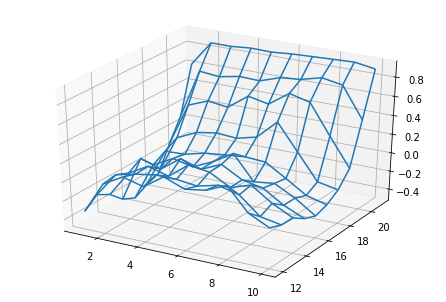

Q-value without Usable Ace


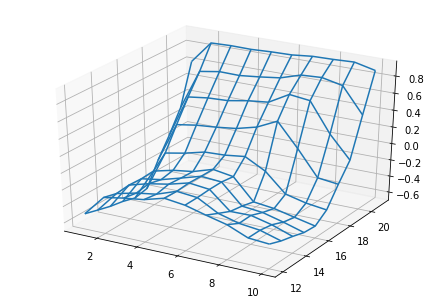

Optimal policy with Usable Ace : (RED : STICK, BLUE : HIT)


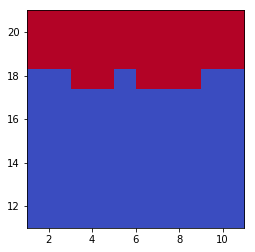

Optimal policy without Usable Ace : (RED : STICK, BLUE : HIT)


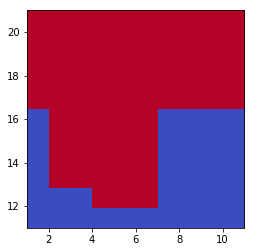

In [9]:
print("Q-value with Usable Ace")
plot_q_val(agent, usable_ace=True)
print("Q-value without Usable Ace")
plot_q_val(agent, usable_ace=False)
print("Optimal policy with Usable Ace : (RED : STICK, BLUE : HIT)")
usable_result = plot_action(agent, usable_ace=True)
print("Optimal policy without Usable Ace : (RED : STICK, BLUE : HIT)")
no_usable_result = plot_action(agent, usable_ace=False)


----
## 9. 과제

### 목표 
위 코드로부터 최적 Policy를 학습시킨 Agent를 사용하여, 블랙잭 게임을 시뮬레이션한 뒤 승률을 계산.

### 초기 설정
 - 플레이어는 1,000,000번의 에피소드로부터 최적 Policy를 학습
 - 플레이어의 초기 자금 : 10,000 달러
 - 플레이어는 게임 참가 시 10 달러를 지불, 결과에 따라 금액을 획득
     - 승리 시 : 20 달러 획득
     - 무승부 시 : 10 달러 획득
     - 패배 시 : 0 달러 획득

### 요구사항
 - 플레이어와 딜러가 1,000번의 게임을 진행
 - 1,000번의 게임 후 플레이어의 승률을 계산
 - 매 게임 별 플레이어의 소지금 변화를 그래프로 시각화

#### * HINT : MonteCarlo 클래스의 generate_episode(), train() 메소드를 참고할 것
----
### (과제 1) 1,000번의 게임 진행

In [10]:
############### 코드 작성 ##############################

############### 코드 작성 ##############################


class test_MonteCarlo(object):
    
    def __init__(self):
        self.money=list()
        self.money.append(10000)
        self.twin=0
        self.tloss=0
        self.tdraw=0
        
    
    def generate_episode(self, dealer: Dealer, agent: Agent, deck: Deck):
        """
        하나의 에피소드(게임)를 생성함
        :param dealer:
        :param agent:
        :param deck:
        :return:
        """
        
        # 카드 덱, 딜러, Agent를 초기화
        deck.reset()
        dealer.reset()
        agent.reset()
        agent.hit(deck)
        agent.hit(deck)
        dealer.hit(deck)
        dealer.hit(deck)

        done = False    # 에피소드의 종료 여부

        episode = list()    # 에피소드

        dshow=dealer.show()
        while not done:
            # 에피소드가 끝날 때까지 State, Action, Reward를 생성
            sums = agent.calculate_sum()
            if sums < 12:
                agent.hit(deck)
                continue

            state = (sums, bool(agent.usable_ace), dshow)

            ########   Exploring Start ~!!!!!!!!! : 
            if len(episode) == 0:       # 첫번째 State 일 때는 무작위 Action 선택
                action =agent.random_action()
            else:                       # 그 외에는 Q 테이블에서 큰 값을 갖는 Action 선택
                action = agent.policy(state)
            
            done, reward = dealer.observation(action, agent, deck)  # 에피소드 종료 여부, Reward 계산
            
            # 생성된 State, Action, Reward를 에피소드에 추가
            episode.append([state, action, reward])

        return episode

    def test(self, dealer: Dealer, agent: Agent, deck: Deck, it=1000, verbose=True):
        count = 0
        win = 0
        loss = 0
        draw = 0
        total_win = 0
        total_loss = 0
        total_draw = 0
        result = str()
        for i in range(it):
            count += 1
            episode = self.generate_episode(dealer, agent, deck)
           # agent.update_qval(episode)

            if episode[-1][-1] == 1:
                win += 1
                self.money.append(self.money[i]+10)
            elif episode[-1][-1] == 0:
                draw += 1
                self.money.append(self.money[i])
            else:
                loss += 1
                self.money.append(self.money[i]-10)

            if count % 1000 == 0 and verbose == True:
                total_win += win
                total_loss += loss
                total_draw += draw

                print("========== Training : Episode ", count, " ===========")
                print("Recent 1000 games win rate :{:.3f}%".format(win / (win + loss) * 100))
                print(" -- 1000 Games WIN :", win, "DRAW :", draw, "LOSS :", loss)
                print("Total win rate : {:.3f}%".format(total_win / (total_win + total_loss) * 100))
                print(" -- TOTAL Games WIN :", total_win, "DRAW :", total_draw, "LOSS :", total_loss)

                win = 0
                loss = 0
                draw = 0
        self.twin=total_win
        self.tloss=total_loss
        self.tdraw=total_draw
    
                
t_deck = Deck()
t_dealer = Dealer()
#agent는 새로 만들면 안됨(기존에 학습한 qtable사용)
t_mc_es = test_MonteCarlo()
t_mc_es.test(t_dealer, agent, t_deck, it=1000)  
print(t_mc_es.twin)



########################################################

========== Training : Episode  1000  ===========
Recent 1000 games win rate :36.043%
 -- 1000 Games WIN : 337 DRAW : 65 LOSS : 598
Total win rate : 36.043%
 -- TOTAL Games WIN : 337 DRAW : 65 LOSS : 598
337


### (과제 2) 플레이어의 승률을 계산

In [11]:
print(" -- TOTAL Games WIN :", t_mc_es.twin, "DRAW :", t_mc_es.tdraw, "LOSS :", t_mc_es.tloss)
print("Total win rate : {:.3f}%".format(t_mc_es.twin / (t_mc_es.twin + t_mc_es.tloss) * 100))

 -- TOTAL Games WIN : 337 DRAW : 65 LOSS : 598
Total win rate : 36.043%


### (과제 3) 플레이어의 소지금 변화를 그래프로 시각화

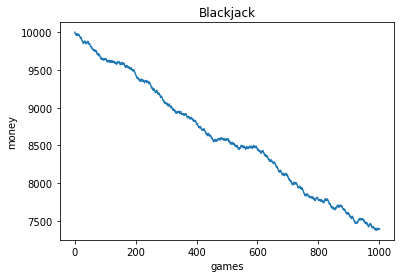

In [12]:
############### 코드 작성 ##############################

def plot_money(tmont:test_MonteCarlo,num):
    games=np.arange(0,num+1)
    plt.title('Blackjack')
    plt.xlabel('games')
    plt.ylabel('money')
    plt.plot(games,tmont.money)
plot_money(t_mc_es,1000)
########################################################

## 추가 과제 : 플레이어의 승률 높이기
State를 수정하여 승률이 더 높은 policy를 찾기

기존 코드의 수정 필요
 - 딜러는 게임이 끝났을 때, 남은 카드의 수를 확인
 - 15장 이상이라면 해당 덱을 다음 게임에서 그대로 사용
 - 15장 미만이라면 52장의 셔플된 새로운 카드를 기존 덱에 추가



In [13]:
############### 코드 작성 ##############################






########################################################

---
### 참고자료
[1] Reinforcement Learning - An Introduction (Richard S. Sutton, Andreow G. Barto), 2nd edition, p.120-124 https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf <br>
[2] matplotlib.pyplot.plot Documentation, https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html <br>
[3] matplotlib.pyplot.plot Examples https://matplotlib.org/tutorials/introductory/pyplot.html